In [1]:
import os

from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import FloatType, StringType, StructType, StructField
from pyspark.ml.linalg import DenseVector
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

import pyspark.ml.stat as stat
import pyspark.sql.functions as F

from matplotlib import pyplot as plt

In [2]:
conf = SparkConf().setMaster('local[*]').setAppName('MLTest')
sc = SparkContext(conf=conf).getOrCreate()
sqlContext = SQLContext(sc)

In [3]:
for file in os.listdir(os.getcwd() + '/in'):
    if 'housing' in file:
        print(file)

cal_housing.data
cal_housing.domain


In [4]:
data = sc.textFile('in/cal_housing.data')
headers = sc.textFile('in/cal_housing.domain')

data = data.map(lambda v: v.split(','))
headers = [header.split(':')[0] for header in headers.collect()]

schema = StructType([StructField(header, StringType(), True)
                     for header in headers])

df = sqlContext.createDataFrame(data, schema)

In [5]:
def convert_to_float(df, columns):
    for column in columns:
        df = df.withColumn(column, df[column].cast(FloatType()))
    return df

df = convert_to_float(df, df.columns)
df.first()

Row(longitude=-122.2300033569336, latitude=37.880001068115234, housingMedianAge=41.0, totalRooms=880.0, totalBedrooms=129.0, population=322.0, households=126.0, medianIncome=8.325200080871582, medianHouseValue=452600.0)

In [6]:
df.printSchema()

root
 |-- longitude: float (nullable = true)
 |-- latitude: float (nullable = true)
 |-- housingMedianAge: float (nullable = true)
 |-- totalRooms: float (nullable = true)
 |-- totalBedrooms: float (nullable = true)
 |-- population: float (nullable = true)
 |-- households: float (nullable = true)
 |-- medianIncome: float (nullable = true)
 |-- medianHouseValue: float (nullable = true)



In [7]:
quantiles = df.approxQuantile(df.columns, [0.05, 0.95], 0.01)

borders = {column: (quantiles[pos][0], quantiles[pos][1]) 
           for pos, column in enumerate(df.columns)}
borders

{'longitude': (-122.4800033569336, -117.08999633789062),
 'latitude': (32.79999923706055, 38.75),
 'housingMedianAge': (8.0, 52.0),
 'totalRooms': (567.0, 5805.0),
 'totalBedrooms': (129.0, 1192.0),
 'population': (337.0, 3108.0),
 'households': (119.0, 1093.0),
 'medianIncome': (1.6197999715805054, 6.9532999992370605),
 'medianHouseValue': (66000.0, 454300.0)}

In [8]:
def feature_engineering(df, target_column):
    columns = df.columns
    if target_column in columns:
        columns.remove(target_column)
    
    for column in columns:
        df = df.withColumn(column + '_IsOutBound', F.col(column).between(borders[column][0], borders[column][1]))
        df = df.withColumn(column + '_IsOutBound', F.col(column + '_IsOutBound').cast(FloatType()))
    
    df = df.withColumn('PopulationPerRooms', F.col('population') / F.col('totalRooms'))
    df = df.withColumn('PopulationPerHouseholds', F.col('population') / F.col('households'))
    df = df.withColumn('RoomsPerHousehold', F.col('totalRooms') / F.col('households'))
    df = df.withColumn('BedroomsPerRoom', F.col('totalBedrooms') / F.col('totalRooms'))
    
    df = df.withColumn(target_column, F.col(target_column) / 100000)
    return df

df = feature_engineering(df, target_column='medianHouseValue')

In [9]:
df.first()

Row(longitude=-122.2300033569336, latitude=37.880001068115234, housingMedianAge=41.0, totalRooms=880.0, totalBedrooms=129.0, population=322.0, households=126.0, medianIncome=8.325200080871582, medianHouseValue=4.526, longitude_IsOutBound=1.0, latitude_IsOutBound=1.0, housingMedianAge_IsOutBound=1.0, totalRooms_IsOutBound=1.0, totalBedrooms_IsOutBound=1.0, population_IsOutBound=0.0, households_IsOutBound=1.0, medianIncome_IsOutBound=0.0, PopulationPerRooms=0.3659090909090909, PopulationPerHouseholds=2.5555555555555554, RoomsPerHousehold=6.984126984126984, BedroomsPerRoom=0.14659090909090908)

In [10]:
target_columns = 'medianHouseValue'
columns = df.columns
if target_columns in columns:
    columns.remove(target_columns)

columns = [target_columns] + columns

In [11]:
df = df.select(columns)
df.first()

Row(medianHouseValue=4.526, longitude=-122.2300033569336, latitude=37.880001068115234, housingMedianAge=41.0, totalRooms=880.0, totalBedrooms=129.0, population=322.0, households=126.0, medianIncome=8.325200080871582, longitude_IsOutBound=1.0, latitude_IsOutBound=1.0, housingMedianAge_IsOutBound=1.0, totalRooms_IsOutBound=1.0, totalBedrooms_IsOutBound=1.0, population_IsOutBound=0.0, households_IsOutBound=1.0, medianIncome_IsOutBound=0.0, PopulationPerRooms=0.3659090909090909, PopulationPerHouseholds=2.5555555555555554, RoomsPerHousehold=6.984126984126984, BedroomsPerRoom=0.14659090909090908)

In [12]:
def create_feature_vector(df):
    input_data = df.rdd.map(lambda v: (v[0], DenseVector(v[1:])))
    df_total = sqlContext.createDataFrame(input_data, ['label', 'features'])
    return df_total

df_total = create_feature_vector(df)
df_total.first()

Row(label=4.526, features=DenseVector([-122.23, 37.88, 41.0, 880.0, 129.0, 322.0, 126.0, 8.3252, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.3659, 2.5556, 6.9841, 0.1466]))

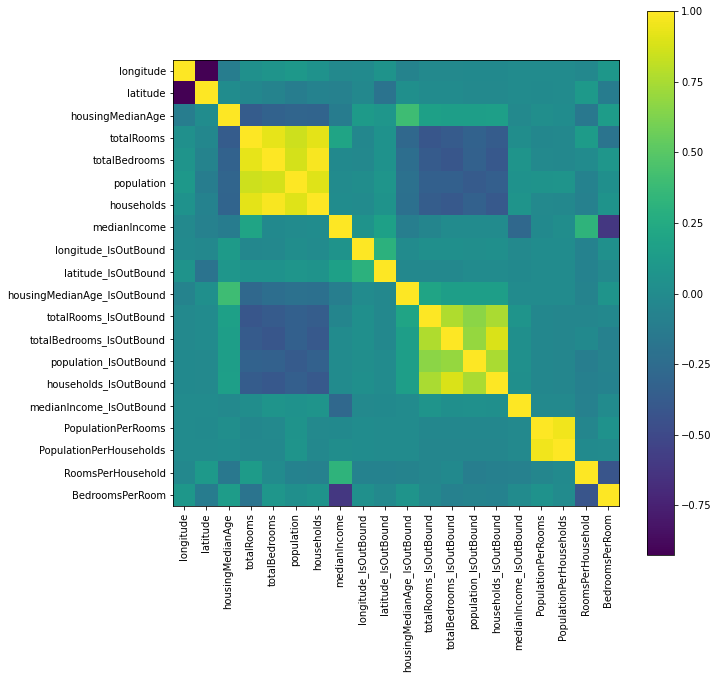

In [13]:
corr_result = stat.Correlation.corr(df_total, 'features')

plt.figure(figsize=(10, 10))
plt.imshow(corr_result.head()[0].toArray())
plt.xticks(range(len(df.columns) - 1), df.columns[1:], rotation=90)
plt.yticks(range(len(df.columns) - 1), df.columns[1:])
_ = plt.colorbar()

In [14]:
df_train, df_test = df_total.randomSplit([0.8, 0.2], seed=241)

print(f'Train size: {df_train.count()}')
print(f'Test size: {df_test.count()}')

Train size: 16539
Test size: 4101


In [15]:
scaler = StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='scaled_features')
scaler = scaler.fit(df_train)

df_train = scaler.transform(df_train)
df_test = scaler.transform(df_test)

In [16]:
kmeans = KMeans(k=10, featuresCol='scaled_features', predictionCol='kmeans_prediction')
kmeans = kmeans.fit(df_train)

In [17]:
df_train = kmeans.transform(df_train)
df_test = kmeans.transform(df_test)

In [18]:
one_hot_encoder = OneHotEncoder(inputCols=['kmeans_prediction'], outputCols=['one_hot_kmeans'])
one_hot_encoder = one_hot_encoder.fit(df_train)

In [19]:
df_train = one_hot_encoder.transform(df_train)
df_test = one_hot_encoder.transform(df_test)

In [20]:
assembler = VectorAssembler(inputCols=['scaled_features', 'one_hot_kmeans'], outputCol='all_features')
df_train = assembler.transform(df_train)
df_test = assembler.transform(df_test)

In [21]:
regressor = RandomForestRegressor(featuresCol='all_features', 
                                  labelCol='label',
                                  predictionCol='prediction', 
                                  maxDepth=6, 
                                  numTrees=100,
                                  seed=241)

regressor = regressor.fit(df_train)
prediction = regressor.transform(df_test)

In [22]:
prediction.select('label', 'prediction').show(20)

+-----+------------------+
|label|        prediction|
+-----+------------------+
|0.175| 2.145963974914629|
|0.266|1.0699973419951805|
|0.367|0.8745357969731883|
|0.375|2.0908229792124815|
|0.375|0.9880873578792695|
|0.388|1.0175972720590907|
|0.392|  1.01356147526297|
|0.438|0.9826644690361378|
| 0.44|0.9159971131872199|
|0.444|0.9117345295960746|
|0.445| 0.913476389164555|
|0.466| 0.913476389164555|
|0.469|1.0083426921078094|
|0.475| 0.910627502026813|
|0.475|1.2096813013210586|
|0.475|2.7446844533344836|
|0.477|1.1152854697011336|
|0.485|0.9495337442836219|
|0.489|0.9595340232967279|
| 0.49|0.9140699649393618|
+-----+------------------+
only showing top 20 rows



In [23]:
rmse_evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')
mae_evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mae')

rmse = rmse_evaluator.evaluate(prediction)
mae = mae_evaluator.evaluate(prediction)

print(rmse, mae)

0.662209232375758 0.4791145282089673
